# Domain Adversarial training of Neural Networks

This notebook walks through the implementation of DANN algorithm to adapt domain from MNIST to MNIST_M.
First, clone the git repository containing utils if not already done :

In [ ]:
# !git clone https://github.com/vcoyette/DANN
# %cd DANN

 ## Dataset
Download the MNIST_M dataset [here](https://drive.google.com/drive/folders/0B_tExHiYS-0vR2dNZEU4NGlSSW8), the office dataset [here](https://drive.google.com/file/d/0B4IapRTv9pJ1WGZVd1VDMmhwdlE/view), the synthetic signs [here](https://www.dropbox.com/s/7izi9lccg163on1/synthetic_data.zip?dl=0) and the GTSRB [here](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html). Place the archives in the data folder.

In [ ]:
# # Untar the mnist_m dataset:
# !tar -xf data/mnist_m.tar.gz -C data/

# # Untar the office dataset:
# !mkdir data/office
# !tar -xf data/domain_adaptation_images.tar.gz -C data/office

# # Unzip the Syn Sign dataset:
# !mkdir data/synsigns
# !unzip data/synthetic_data.zip
# !mv synthetic_data synsigns

# # Unzip GTSRB dataset:
# !unzip data/GTSRB_Final_Training_Images.zip

## Initialisation

In [1]:
import sys
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages')
sys.path.append('/mnt/c/MyPrograms/__github/DANN_vcoyette/')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sklearn

from task_definition import tasks
from testDANN import testBaseLine, testDANN


from sklearn import svm

def predictSVC(Xtrain,ytrain,Xtest,ytest,C=1,gamma='auto',printresult=True,normalize=False,verbose=True):
    if verbose:
        print('Xtrain shape=',Xtrain.shape)
    classifier = svm.LinearSVC(C=C)
    X = Xtrain
    if normalize:
        X = sklearn.preprocessing.normalize(X).copy()
    classifier.fit(X, ytrain)
    predicted_labels_train = classifier.predict(X)
    if printresult:
        print(confusion_matrix(ytrain, predicted_labels_train))
        print('Accuracy train:',accuracy_score(ytrain, predicted_labels_train))
    Xt = Xtest
    if normalize:
        Xt = sklearn.preprocessing.normalize(Xt).copy()        
    predicted_labels_test = classifier.predict(Xt)
    if printresult:
        print(confusion_matrix(ytest, predicted_labels_test))
        print('Accuracy test:',accuracy_score(ytest, predicted_labels_test))
    return accuracy_score(ytrain, predicted_labels_train), accuracy_score(ytest, predicted_labels_test), classifier

def predictLogReg(Xtrain,ytrain,Xtest,ytest,C=1,gamma='auto',printresult=True,normalize=False,verbose=True):
    if verbose:
        print('Xtrain shape=',Xtrain.shape)
    classifier = sklearn.linear_model.LogisticRegression(C=C)
    X = Xtrain
    if normalize:
        X = sklearn.preprocessing.normalize(X).copy()
    classifier.fit(X, ytrain)
    predicted_labels_train = classifier.predict(X)
    if printresult:
        print(confusion_matrix(ytrain, predicted_labels_train))
        print('Accuracy train:',accuracy_score(ytrain, predicted_labels_train))
    Xt = Xtest
    if normalize:
        Xt = sklearn.preprocessing.normalize(Xt).copy()        
    predicted_labels_test = classifier.predict(Xt)
    if printresult:
        print(confusion_matrix(ytest, predicted_labels_test))
        print('Accuracy test:',accuracy_score(ytest, predicted_labels_test))
    return accuracy_score(ytrain, predicted_labels_train), accuracy_score(ytest, predicted_labels_test), classifier


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

False


# Task selection

Select the domain adaptation task to perform:

In [3]:
# Select source and target domains
# Available values:
#   0. MNIST to MNIST_M
#   1. SVHN to MNIST
#   2. AMAZON to WEBCAM
#   3. Syn Signs to GTSRB
domain = 0
source_name = 'MNIST'
target_name = 'MNIST_M'
#source_name = 'SVHN'
#target_name = 'MNIST'
#source_name = 'AMAZON'
#target_name = 'WEBCAM'
folder_name = source_name+"_"+target_name

The tasks are defined in the task_selection.py file. Let's extract utils and networks for the specified task:

In [5]:
task = tasks[domain]

In [6]:
load_source = task.load_source
load_target = task.load_target
FeatureExtractor = task.feature_extractor
Classifier = task.classifier
DomainRegressor = task.domain_regressor
schedule_lr = task.schedule_lr

## Load Dataset

Load the source and target datasets:

In [7]:
batch_size = 64

trainloader_source, testloader_source = load_source(batch_size=batch_size,
                                                    shuffle=True,
                                                    num_workers=2,
                                                    drop_last=True)
trainloader_target, testloader_target = load_target(batch_size=batch_size, 
                                                    shuffle=True, 
                                                    num_workers=2,
                                                    drop_last=True)

/home/zinovyev/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Let's plot some images:

In [75]:
print(trainloader_target.dataset)

Source Domain batch


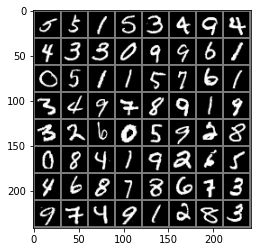

Target Domain batch


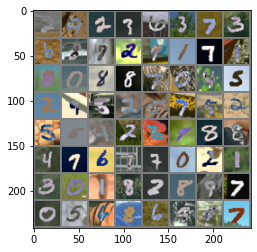

In [76]:
#functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images from source
dataiter = iter(trainloader_source)
images, labels = dataiter.next()

print('Source Domain batch')

# show images
imshow(torchvision.utils.make_grid(images))

# get some random training images from target
dataiter = iter(trainloader_target)
images, labels = dataiter.next()

print('Target Domain batch')

# show images
imshow(torchvision.utils.make_grid(images))

In [42]:
# Save dataset as .mat file

from scipy.io import savemat

print(np.array(images.data).shape)
sz = 0
for i, data in enumerate(trainloader_source):
    inputs, labels = data[0].to(device), data[1].to(device)
    Xa = inputs.numpy()
    sz = sz+Xa.shape[0]
print(sz)
X = np.zeros([sz,28,28,3])
y = np.zeros(sz)
k = 0
for i, data in enumerate(trainloader_source):
    inputs, labels = data[0].to(device), data[1].to(device)
    Xa = inputs.numpy()
    n = Xa.shape[0]
    X[k:k+n,:,:,0] = Xa[:,0,:,:]
    X[k:k+n,:,:,1] = Xa[:,1,:,:]
    X[k:k+n,:,:,2] = Xa[:,2,:,:]
    y[k:k+n] = labels.numpy()
    k = k+n
X = X.reshape(sz,2352)
print(X.shape,y.shape)

savemat(source_name+'_train.mat', {'data':X,'labels':y},do_compression=True)

(64, 3, 28, 28)
73216
(73216, 2352) (73216,)


# Baseline

Let's consider as a baseline a network trained on the source domain only. To remain consistent with the DANN implementation, we will use the same components (feature extractor and classifier).

In [8]:
class Net(nn.Module):
    def __init__(self, feature_extractor, classifier):
        super(Net, self).__init__()

        self.feature_extractor = feature_extractor
        self.classifier = classifier

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)

        return x

basenet = Net(FeatureExtractor(), Classifier()).to(device)

In [10]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(basenet.parameters(), lr=0.001, momentum=0.9)

In [13]:
subsample_size = 5000

for epoch in range(10):

    n = 0

    print(f'Training epoch {epoch}...')

    for i, data in enumerate(trainloader_source):
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = basenet(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        n+=len(labels)
        if subsample_size>0:
            if n>subsample_size:
                break
        

print('Finished Training')

torch.save(basenet.state_dict(), '/mnt/c/MyPrograms/Python/DAPCA/DANN_vcoyette/cnn_domain'+str(domain))

Training epoch 0...
Training epoch 1...
Training epoch 2...
Training epoch 3...
Training epoch 4...
Training epoch 5...
Training epoch 6...
Training epoch 7...
Training epoch 8...
Training epoch 9...
Finished Training


In [27]:
torch.save(basenet.state_dict(), '/mnt/c/MyPrograms/Python/DAPCA/DANN_vcoyette/cnn_domain'+str(domain))

In [51]:
basenet = Net(FeatureExtractor(), Classifier()).to(device)
basenet.load_state_dict(torch.load('/mnt/c/MyPrograms/Python/DAPCA/DANN_vcoyette/cnn_domain'+str(domain)))
basenet.eval()

Net(
  (feature_extractor): FeatureExtractor(
    (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=768, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=10, bias=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (logsoftmax): LogSoftmax(dim=1)
  )
)

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def testBaseLine(network, testloader):
    """Test the network on the test data loaer.

    Keyword Arguments:
        network -- the neural network to test
        device -- the device on which the network is
        testloader -- the dataloader for the dataset
    """
    device = next(network.parameters()).device

    correct = 0
    total = 0
    k = 0
    labels_all = []
    predicted_all = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = network(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            labels_all = list(labels)+labels_all
            predicted_all = list(predicted)+predicted_all
    print(confusion_matrix(labels_all,predicted_all))
    print('total:',len(predicted_all))
    print('Accuracy test:',accuracy_score(labels_all, predicted_all))
    return outputs, correct / total * 100


outputs_source, acc_source = testBaseLine(basenet, testloader_source)

print(f'Accuracy on the source test images:'
      f'{acc_source} %')



outputs_target, acc_target = testBaseLine(basenet, testloader_target)

print(f'Accuracy on the target test images:'
      f'{acc_target} %')

[[ 958    0    0    3    0    6    4    1    6    0]
 [   0 1060    4   23    3    2    4    5   33    0]
 [  16    1  907   14   15    1   15   20   27   15]
 [   3    0   12  948    0    9    0   13   19    5]
 [   1    0    3    0  887    0   15    1    5   69]
 [  16    2    1   65    6  741   13    4   31   10]
 [  18    2    5    2   24   13  888    0    3    0]
 [   1    8   26    9    3    2    0  905    8   64]
 [  18    1    3   48   10   13    1    7  852   20]
 [  13    3    5   13   18    6    0   27    6  917]]
total: 9984
Accuracy test: 0.9077524038461539
Accuracy on the source test images:90.77524038461539 %
[[448   0  49 146   6   4  45   8 148  22]
 [203 332  66 144  21   9  33  14 154  32]
 [126   0 408 147  10  57  21  16 113  31]
 [101   1  89 467   3  21  41   4 158  18]
 [175   0  19  97 321  10  16   4 116 128]
 [ 70   0  89 138  11 238  50   1 188  19]
 [131   0  23 102  44  15 421   4  94  18]
 [ 78   2 129  97   8  12  26 301 129 129]
 [152   0  44  89   6  1

In [51]:
print(basenet)

Net(
  (feature_extractor): FeatureExtractor(
    (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=512, out_features=3072, bias=True)
    (fc2): Linear(in_features=3072, out_features=2048, bias=True)
    (fc3): Linear(in_features=2048, out_features=10, bias=True)
    (logsoftmax): LogSoftmax(dim=1)
  )
)


In [20]:
## SAVE ENCODED IMAGES USING ONLY SOURCE

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

#basenet.feature_extractor.register_forward_hook(get_features('feats'))
feature_name = 'fc2'
basenet.classifier.fc2.register_forward_hook(get_features('fc2'))

def get_feature_output(net,loader,feature_name):
    # placeholders
    PREDS = []
    FEATS = []
    # placeholder for batch features
    features = {}
    # loop through batches
    for idx, data in enumerate(loader):
        # move to device
        images, labels = data[0].to(device), data[1].to(device)
        # forward pass [with feature extraction]
        preds = net(images)
        # add feats and preds to lists
        PREDS.append(preds.detach().cpu().numpy())
        FEATS.append(features[feature_name].cpu().numpy())
        # early stop
        #if idx == 9:
        #    break
    PREDS = np.concatenate(PREDS)
    FEATS = np.concatenate(FEATS)
    return FEATS

PREDS = []
FEATS = []
labels_train_source = []
# placeholder for batch features
features = {}
# loop through batches
for idx, data in enumerate(trainloader_source):
    # move to device
    images, labels = data[0].to(device), data[1].to(device)
    labels_train_source.append(labels.numpy())
    # forward pass [with feature extraction]
    preds = basenet(images)
    # add feats and preds to lists
    PREDS.append(preds.detach().cpu().numpy())
    FEATS.append(features[feature_name].cpu().numpy())
    # early stop
    #if idx == 9:
    #    break
PREDS = np.concatenate(PREDS)
FEATS = np.concatenate(FEATS)
labels_train_source = np.concatenate(labels_train_source)
#print('- preds shape:', PREDS.shape)
#print('- feats shape:', FEATS.shape)
Source_encoded = FEATS
print('- feats shape - source:', Source_encoded.shape)

PREDS = []
FEATS = []
# placeholder for batch features
features = {}
# loop through batches
labels_train_target = []
for idx, data in enumerate(trainloader_target):
    # move to device
    images, labels = data[0].to(device), data[1].to(device)
    labels_train_target.append(labels.numpy())
    # forward pass [with feature extraction]
    preds = basenet(images)
    # add feats and preds to lists
    PREDS.append(preds.detach().cpu().numpy())
    FEATS.append(features[feature_name].cpu().numpy())
    # early stop
    #if idx == 9:
    #    break
PREDS = np.concatenate(PREDS)
FEATS = np.concatenate(FEATS)
labels_train_target = np.concatenate(labels_train_target)
#print('- preds shape:', PREDS.shape)
#print('- feats shape:', FEATS.shape)
Target_encoded = FEATS
#print('- preds shape:', PREDS.shape)
#print('- feats shape:', FEATS.shape)
print('- feats shape - target:', Target_encoded.shape)

PREDS = []
FEATS = []
# placeholder for batch features
features = {}
# loop through batches
labels_test_source = []
for idx, data in enumerate(testloader_source):
    # move to device
    images, labels = data[0].to(device), data[1].to(device)
    labels_test_source.append(labels.numpy())
    # forward pass [with feature extraction]
    preds = basenet(images)
    # add feats and preds to lists
    PREDS.append(preds.detach().cpu().numpy())
    FEATS.append(features[feature_name].cpu().numpy())
    # early stop
    #if idx == 9:
    #    break
PREDS = np.concatenate(PREDS)
FEATS = np.concatenate(FEATS)
labels_test_source = np.concatenate(labels_test_source)
#print('- preds shape:', PREDS.shape)
#print('- feats shape:', FEATS.shape)
Source_test_encoded = FEATS
#print('- preds shape:', PREDS.shape)
#print('- feats shape:', FEATS.shape)
print('- feats shape - source test:', Source_test_encoded.shape)

PREDS = []
FEATS = []
# placeholder for batch features
features = {}
# loop through batches
labels_test_target = []
for idx, data in enumerate(testloader_target):
    # move to device
    images, labels = data[0].to(device), data[1].to(device)
    labels_test_target.append(labels.numpy())
    # forward pass [with feature extraction]
    preds = basenet(images)
    # add feats and preds to lists
    PREDS.append(preds.detach().cpu().numpy())
    FEATS.append(features[feature_name].cpu().numpy())
    # early stop
    #if idx == 9:
    #    break
PREDS = np.concatenate(PREDS)
FEATS = np.concatenate(FEATS)
labels_test_target = np.concatenate(labels_test_target)
#print('- preds shape:', PREDS.shape)
#print('- feats shape:', FEATS.shape)
Target_test_encoded = FEATS
#print('- preds shape:', PREDS.shape)
#print('- feats shape:', FEATS.shape)


#Source_encoded = get_feature_output(basenet,trainloader_source,'fc2')
#Target_encoded = get_feature_output(basenet,trainloader_target,'fc2')
print('- feats shape - target test:', Target_test_encoded.shape)

- feats shape - source: (73216, 2048)
- feats shape - target: (59968, 2048)
- feats shape - source test: (25984, 2048)
- feats shape - target test: (9984, 2048)


In [21]:
from scipy.io import savemat
folder_out = '/mnt/c/Datas/DAPCA/'+folder_name+'/'
savemat(folder_out+target_name+'_train_codedNNpt.mat', {'data':Target_encoded,'labels':labels_train_target},do_compression=True)
savemat(folder_out+target_name+'_test_codedNNpt.mat', {'data':Target_test_encoded,'labels':labels_test_target},do_compression=True)
savemat(folder_out+source_name+'_train_codedNNpt.mat', {'data':Source_encoded,'labels':labels_train_source},do_compression=True)
savemat(folder_out+source_name+'_test_codedNNpt.mat', {'data':Source_test_encoded,'labels':labels_test_source},do_compression=True)

In [53]:
#predictSVC(Target_encoded[:10000,:],labels_train_target[:10000],Target_test_encoded,labels_test_target)
#predictSVC(Source_encoded[:10000,:],labels_train_source[:10000],Source_test_encoded,labels_test_source)
#predictLogReg(Source_encoded[:10000,:],labels_train_source[:10000],Source_test_encoded,labels_test_source)
#predictSVC(Source_encoded[:10000,:],labels_train_source[:10000],Target_test_encoded,labels_test_target)
#_,_,_ = predictLogReg(Source_encoded[:10000,:],labels_train_source[:10000],Target_test_encoded,labels_test_target)
_,_,_ = predictLogReg(Source_encoded,labels_train_source,Target_test_encoded,labels_test_target)

Xtrain shape= (73216, 2048)


/home/zinovyev/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[[ 4535   129    33    23    29     5    65    15    44    66]
 [  100 13155    75   104   174    27    46   113    36    23]
 [   29   124  9979   113    79    24    11   106    49    64]
 [   24   140   150  7585    64   249    52    52   116    62]
 [   25   195    67    58  6928    31    51    14    39    46]
 [    4    49    41   299    53  6161   162    16    43    51]
 [   79    49    26    66    63   141  5091    11   164    36]
 [   26   183   114    56    30    16    11  5124    10    18]
 [   57    80    58   130    37    51   159    13  4365    93]
 [   77    53   102    86    51    67    28    22    58  4113]]
Accuracy train: 0.9155922202797203
[[472   0 394  28  62   0  13   5   2   2]
 [  0 851   4   1 216   0   0  60   0   0]
 [ 27   3 547 365  19   5   1  28  25  11]
 [  1   0   5 926   1  31   4   4  15  21]
 [  0  21  20  42 849   0   7  12   1  30]
 [  0   4   3  60   4 763  28   4   3  19]
 [ 22   4  18  33 486  57 283   2   1  52]
 [  0  31  64  52  12  16   2 836

## DANN
Here is the general architecture of a DANN network :

![General Architecture](img/archi.png)

We will define 3 torch modules:
1. A feature Extractor (green)
1. A classifier (blue)
1. A Domain Regressor (pink)

We will use for each module the specific architecture defined for MNIST to MNIST_M transfer in the paper:

![Network Architecture](img/network.png)

The modules are defined in the file models.py.

Let's define our Gradient reversal layer : 
(discussion here: https://discuss.pytorch.org/t/solved-reverse-gradients-in-backward-pass/3589)

In [8]:
class GradReverse(torch.autograd.Function):
    """Extension of grad reverse layer."""
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        grad_output = grad_output.neg()
        return grad_output, None

    def grad_reverse(x):
        return GradReverse.apply(x)

We can now integrate all our modules in a single DANN network.

In [9]:
class DANN(nn.Module):
    def __init__(self, feature_extractor, domain_regressor, classifier):
        super(DANN, self).__init__()

        self.feature_extractor = feature_extractor
        self.domain_regressor = domain_regressor
        self.classifier = classifier

    def forward(self, x):
        x = self.feature_extractor(x)
        y = GradReverse.grad_reverse(x)
        return self.classifier(x), self.domain_regressor(y)

net = DANN(FeatureExtractor(), DomainRegressor(), Classifier()).to(device)

Let's define training parameters:

In [10]:
# Number of epochs
NUM_EPOCH = 100
# Length of an epoch
LEN_EPOCH = min(len(trainloader_source), len(trainloader_target))

# Total steps in the training
total_steps = NUM_EPOCH * LEN_EPOCH

# Define criterions
criterion_classifier = nn.NLLLoss()
criterion_domain_regressor = nn.NLLLoss()

We will use an SGD with a momentum of 0.9 and an adaptative learning rate as follow:
$$
\mu_p = \frac{\mu_0}{(1+\alpha \cdot p)^\beta}
$$
With:
$$
\mu_0 = 0.01\\
\alpha = 10\\
\beta = 0.75\\
p \text{ is the training progress linearly changing from 0 to 1}
$$

As stated in the paper, the domain adaptation parameter will be set only for the feature extractor to:
$$
\lambda_p = \frac{2}{1 + e^{-\gamma \cdot p}} - 1
$$
with
$$
\gamma = 10
$$

In order to set the regularization parameter only for the feature extractor, we will define a virtual learning rate of $\mu_p / \lambda_p$ on the domain regressor.



In [11]:
# Params
alpha = 10
beta = 0.75
gamma = 10
mu0 = 0.01
eta = 0.9

# SGD optimizer
optimizer = optim.SGD([{'params': net.feature_extractor.parameters()},
                       {'params': net.classifier.parameters()},
                       {'params': net.domain_regressor.parameters()}], 
                       lr = mu0,
                       momentum = eta)

# Learning rate scheduler 
def mu_p(step):
    if schedule_lr:
        mu_p =  1 / (1 + alpha * step / total_steps) ** beta
    else:
        mu_p = 1
    return mu_p

# Virtual learning rate for the domain regressor
def domain_regressor_lr_scheduler(step):
    # If step=0, just returns mu_p to avoid division by zero
    if step == 0:
        lambda_p = 1
    else:
        # Compute progress
        p = step / total_steps
        
        lambda_p = 2 / (1 + np.exp(-gamma * p)) - 1

    return mu_p(step)/lambda_p
  
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [mu_p, mu_p, domain_regressor_lr_scheduler])

In [12]:
# Initialize progress
p = 0

# Domain targets
labels_domain_source = torch.zeros(batch_size).long().to(device)
labels_domain_target = torch.ones(batch_size).long().to(device)
labels_domain = torch.cat((labels_domain_source, labels_domain_target))

for epoch in range(NUM_EPOCH):

    print(f'Training epoch {epoch}...')

    for data_source, data_target in zip(trainloader_source, trainloader_target):
          
        # Update progress   
        p += 1 / total_steps

        # Compute the regularization term
        lambda_p = 2 / (1 + np.exp(-gamma * p)) - 1

        # Split and transfer to GPU
        image_source, labels_source = data_source[0].to(device), data_source[1].to(device)
        image_taget, labels_target = data_target[0].to(device), data_target[1].to(device)

        # Source forward pass
        src_class, src_domain = net(image_source)

        # Classifier loss
        class_loss = criterion_classifier(src_class, labels_source)

        # Target forward pass
        _, tgt_domain = net(image_taget)

        # Domain Loss
        preds_domain = torch.cat((src_domain, tgt_domain))
        domain_loss = criterion_domain_regressor(preds_domain, labels_domain)

        # Total loss
        loss = class_loss + lambda_p * domain_loss

        # Backward and Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Scheduler step
        scheduler.step()

    print('Testing...')
    print(f'Accuracy on source test dataset: {testDANN(net, testloader_source)} %')
    print(f'Accuracy on taget test dataset: {testDANN(net, testloader_target)} %')

print('Finished Training')

torch.save(net.state_dict(), '/mnt/c/MyPrograms/Python/DAPCA/DANN_vcoyette/dann_domain_'+str(domain))

Training epoch 0...


/home/zinovyev/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Testing...
Accuracy on source test dataset: 82.83943965517241 %
Accuracy on taget test dataset: 56.68068910256411 %
Training epoch 1...
Testing...
Accuracy on source test dataset: 87.11129926108374 %
Accuracy on taget test dataset: 58.31330128205128 %
Training epoch 2...
Testing...
Accuracy on source test dataset: 88.96243842364532 %
Accuracy on taget test dataset: 51.76282051282052 %
Training epoch 3...
Testing...
Accuracy on source test dataset: 87.85791256157636 %
Accuracy on taget test dataset: 57.512019230769226 %
Training epoch 4...
Testing...
Accuracy on source test dataset: 89.36268472906403 %
Accuracy on taget test dataset: 55.69911858974359 %
Training epoch 5...
Testing...
Accuracy on source test dataset: 89.82835591133005 %
Accuracy on taget test dataset: 56.44030448717948 %
Training epoch 6...
Testing...
Accuracy on source test dataset: 89.05095443349754 %
Accuracy on taget test dataset: 49.77964743589743 %
Training epoch 7...
Testing...
Accuracy on source test dataset: 89.

Accuracy on source test dataset: 90.25554187192118 %
Accuracy on taget test dataset: 71.94511217948718 %
Training epoch 61...
Testing...
Accuracy on source test dataset: 90.33251231527095 %
Accuracy on taget test dataset: 72.62620192307693 %
Training epoch 62...
Testing...
Accuracy on source test dataset: 90.36330049261085 %
Accuracy on taget test dataset: 71.61458333333334 %
Training epoch 63...
Testing...
Accuracy on source test dataset: 90.46721059113301 %
Accuracy on taget test dataset: 71.61458333333334 %
Training epoch 64...
Testing...
Accuracy on source test dataset: 90.17087438423646 %
Accuracy on taget test dataset: 72.32572115384616 %
Training epoch 65...
Testing...
Accuracy on source test dataset: 90.1208435960591 %
Accuracy on taget test dataset: 71.69471153846155 %
Training epoch 66...
Testing...
Accuracy on source test dataset: 90.63269704433498 %
Accuracy on taget test dataset: 74.36899038461539 %
Training epoch 67...
Testing...
Accuracy on source test dataset: 90.474907

In [13]:
net.eval()

DANN(
  (feature_extractor): FeatureExtractor(
    (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (domain_regressor): DomainRegressor(
    (fc1): Linear(in_features=512, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=1024, bias=True)
    (fc3): Linear(in_features=1024, out_features=2, bias=True)
    (logsoftmax): LogSoftmax(dim=1)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=512, out_features=3072, bias=True)
    (fc2): Linear(in_features=3072, out_features=2048, bias=True)
    (fc3): Linear(in_features=2048, out_features=10, bias=True)
    (logsoftmax): LogSoftmax(dim=1)
  )
)

In [8]:
net = DANN(FeatureExtractor(), DomainRegressor(), Classifier())
net.load_state_dict(torch.load('/mnt/c/MyPrograms/Python/DAPCA/DANN_vcoyette/dann_domain_'+str(domain)))
net.eval()

DANN(
  (feature_extractor): FeatureExtractor(
    (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (domain_regressor): DomainRegressor(
    (fc1): Linear(in_features=768, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=2, bias=True)
    (logsoftmax): LogSoftmax(dim=1)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=768, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=10, bias=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (logsoftmax): LogSoftmax(dim=1)
  )
)

In [14]:
## SAVE ENCODED IMAGES USING DANN

network = net

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

#network.feature_extractor.register_forward_hook(get_features('feats'))
net.classifier.fc2.register_forward_hook(get_features('fc2'))

def get_feature_output(net,loader,feature_name):
    # placeholders
    PREDS = []
    FEATS = []
    # placeholder for batch features
    features = {}
    # loop through batches
    for idx, data in enumerate(loader):
        # move to device
        images, labels = data[0].to(device), data[1].to(device)
        # forward pass [with feature extraction]
        preds = net(images)
        # add feats and preds to lists
        # PREDS.append(preds.detach().cpu().numpy())
        FEATS.append(features['fc2'].cpu().numpy())
        # early stop
        #if idx == 9:
        #    break
    PREDS = np.concatenate(PREDS)
    FEATS = np.concatenate(FEATS)
    return FEATS

PREDS = []
FEATS = []
labels_train_source = []
# placeholder for batch features
features = {}
# loop through batches
feature_name = 'fc2'
for idx, data in enumerate(trainloader_source):
    # move to device
    images, labels = data[0].to(device), data[1].to(device)
    labels_train_source.append(labels.numpy())
    # forward pass [with feature extraction]
    preds = network(images)
    # add feats and preds to lists
    PREDS.append(preds[0].detach().cpu().numpy())
    FEATS.append(features[feature_name].cpu().numpy())
    # early stop
    #if idx == 9:
    #    break
PREDS = np.concatenate(PREDS)
FEATS = np.concatenate(FEATS)
labels_train_source = np.concatenate(labels_train_source)
#print('- preds shape:', PREDS.shape)
#print('- feats shape:', FEATS.shape)
Source_encoded = FEATS
print('- feats shape - source:', Source_encoded.shape)

PREDS = []
FEATS = []
# placeholder for batch features
features = {}
# loop through batches
feature_name = 'fc2'
labels_train_target = []
for idx, data in enumerate(trainloader_target):
    # move to device
    images, labels = data[0].to(device), data[1].to(device)
    labels_train_target.append(labels.numpy())
    # forward pass [with feature extraction]
    preds = network(images)
    # add feats and preds to lists
    PREDS.append(preds[0].detach().cpu().numpy())
    FEATS.append(features[feature_name].cpu().numpy())
    # early stop
    #if idx == 9:
    #    break
PREDS = np.concatenate(PREDS)
FEATS = np.concatenate(FEATS)
labels_train_target = np.concatenate(labels_train_target)
#print('- preds shape:', PREDS.shape)
#print('- feats shape:', FEATS.shape)
Target_encoded = FEATS
#print('- preds shape:', PREDS.shape)
#print('- feats shape:', FEATS.shape)
print('- feats shape - target:', Target_encoded.shape)

PREDS = []
FEATS = []
# placeholder for batch features
features = {}
# loop through batches
feature_name = 'fc2'
labels_test_source = []
for idx, data in enumerate(testloader_source):
    # move to device
    images, labels = data[0].to(device), data[1].to(device)
    labels_test_source.append(labels.numpy())
    # forward pass [with feature extraction]
    preds = network(images)
    # add feats and preds to lists
    PREDS.append(preds[0].detach().cpu().numpy())
    FEATS.append(features[feature_name].cpu().numpy())
    # early stop
    #if idx == 9:
    #    break
PREDS = np.concatenate(PREDS)
FEATS = np.concatenate(FEATS)
labels_test_source = np.concatenate(labels_test_source)
#print('- preds shape:', PREDS.shape)
#print('- feats shape:', FEATS.shape)
Source_test_encoded = FEATS
#print('- preds shape:', PREDS.shape)
#print('- feats shape:', FEATS.shape)
print('- feats shape - source test:', Source_test_encoded.shape)

PREDS = []
FEATS = []
# placeholder for batch features
features = {}
# loop through batches
feature_name = 'fc2'
labels_test_target = []
for idx, data in enumerate(testloader_target):
    # move to device
    images, labels = data[0].to(device), data[1].to(device)
    labels_test_target.append(labels.numpy())
    # forward pass [with feature extraction]
    preds = network(images)
    # add feats and preds to lists
    PREDS.append(preds[0].detach().cpu().numpy())
    FEATS.append(features[feature_name].cpu().numpy())
    # early stop
    #if idx == 9:
    #    break
PREDS = np.concatenate(PREDS)
FEATS = np.concatenate(FEATS)
labels_test_target = np.concatenate(labels_test_target)
#print('- preds shape:', PREDS.shape)
#print('- feats shape:', FEATS.shape)
Target_test_encoded = FEATS
#print('- preds shape:', PREDS.shape)
#print('- feats shape:', FEATS.shape)


#Source_encoded = get_feature_output(network,trainloader_source,'fc2')
#Target_encoded = get_feature_output(network,trainloader_target,'fc2')
print('- feats shape - target test:', Target_test_encoded.shape)

- feats shape - source: (73216, 2048)
- feats shape - target: (59968, 2048)
- feats shape - source test: (25984, 2048)
- feats shape - target test: (9984, 2048)


In [15]:
from scipy.io import savemat
folder_out = '/mnt/c/Datas/DAPCA/'+folder_name+'/'
savemat(folder_out+target_name+'_train_codedDANN.mat', {'data':Target_encoded,'labels':labels_train_target},do_compression=True)
savemat(folder_out+target_name+'_test_codedDANN.mat', {'data':Target_test_encoded,'labels':labels_test_target},do_compression=True)
savemat(folder_out+source_name+'_train_codedDANN.mat', {'data':Source_encoded,'labels':labels_train_source},do_compression=True)
savemat(folder_out+source_name+'_test_codedDANN.mat', {'data':Source_test_encoded,'labels':labels_test_source},do_compression=True)